In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)

100%|██████████| 11.4M/11.4M [00:00<00:00, 86.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
files = os.listdir(path)
names = []
for file in files:
  names.append(file.split('.')[0])
  print(file)
print()
print('Names:- ',names)

DOM_hourly.csv
est_hourly.paruqet
AEP_hourly.csv
COMED_hourly.csv
NI_hourly.csv
EKPC_hourly.csv
PJME_hourly.csv
DEOK_hourly.csv
DAYTON_hourly.csv
PJM_Load_hourly.csv
DUQ_hourly.csv
pjm_hourly_est.csv
FE_hourly.csv
PJMW_hourly.csv

Names:-  ['DOM_hourly', 'est_hourly', 'AEP_hourly', 'COMED_hourly', 'NI_hourly', 'EKPC_hourly', 'PJME_hourly', 'DEOK_hourly', 'DAYTON_hourly', 'PJM_Load_hourly', 'DUQ_hourly', 'pjm_hourly_est', 'FE_hourly', 'PJMW_hourly']


In [ ]:
for file in files:
  file_path = os.path.join(path, file)
  if file_path.endswith('.csv'):
    df = pd.read_csv(file_path)
    print(df.head())
  else:
    df = pd.read_parquet(file_path)
    print(df.head())

              Datetime  DOM_MW
0  2005-12-31 01:00:00  9389.0
1  2005-12-31 02:00:00  9070.0
2  2005-12-31 03:00:00  9001.0
3  2005-12-31 04:00:00  9042.0
4  2005-12-31 05:00:00  9132.0
                           AEP  COMED  DAYTON  DEOK  DOM  DUQ  EKPC  FE  NI  \
Datetime                                                                      
1998-12-31 01:00:00+00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   
1998-12-31 02:00:00+00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   
1998-12-31 03:00:00+00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   
1998-12-31 04:00:00+00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   
1998-12-31 05:00:00+00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   

                           PJME  PJMW  PJM_Load  
Datetime                                         
1998-12-31 01:00:00+00:00   NaN   NaN   29309.0  
1998-12-31 02:00:00+00:00   NaN   NaN   28236.0  
1998-12-31 03:00:00+00:00   NaN   NaN   27692.0  
1998-12-31

In [ ]:
dfs = []
for file in files:
  file_path = os.path.join(path, file)
  if file_path.endswith('.csv'):
    df = pd.read_csv(file_path)
  if file_path.endswith('.paruqet'):
    df = pd.read_parquet(file_path)
  if df.index.name == 'Datetime':
    df.reset_index(inplace=True)
  first_column = 'Datetime'
  last_column = df.columns[-1]
  df[first_column] = pd.to_datetime(df[first_column], errors='coerce').dt.tz_localize(None)
  new_df = df[[first_column, last_column]]
  new_df = new_df.rename(columns = {f'{last_column}': 'MW'})
  dfs.append(new_df)


In [ ]:
dfs

[                  Datetime       MW
 0      2005-12-31 01:00:00   9389.0
 1      2005-12-31 02:00:00   9070.0
 2      2005-12-31 03:00:00   9001.0
 3      2005-12-31 04:00:00   9042.0
 4      2005-12-31 05:00:00   9132.0
 ...                    ...      ...
 116184 2018-01-01 20:00:00  18418.0
 116185 2018-01-01 21:00:00  18567.0
 116186 2018-01-01 22:00:00  18307.0
 116187 2018-01-01 23:00:00  17814.0
 116188 2018-01-02 00:00:00  17428.0
 
 [116189 rows x 2 columns],
                   Datetime       MW
 0      1998-12-31 01:00:00  29309.0
 1      1998-12-31 02:00:00  28236.0
 2      1998-12-31 03:00:00  27692.0
 3      1998-12-31 04:00:00  27596.0
 4      1998-12-31 05:00:00  27888.0
 ...                    ...      ...
 178257 2018-01-01 20:00:00      NaN
 178258 2018-01-01 21:00:00      NaN
 178259 2018-01-01 22:00:00      NaN
 178260 2018-01-01 23:00:00      NaN
 178261 2018-01-02 00:00:00      NaN
 
 [178262 rows x 2 columns],
                   Datetime       MW
 0      2004-12

In [ ]:
df = pd.concat(dfs, ignore_index= True)

In [ ]:
df = df.dropna(subset=['MW'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1155959 entries, 0 to 1446690
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   Datetime  1155959 non-null  datetime64[ns]
 1   MW        1155959 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.5 MB


In [ ]:
df.isnull().sum()

,0
Datetime,0
MW,0


In [ ]:
df['MW_Lag1'] = df['MW'].shift(1)
df['MW_Lag24'] = df['MW'].shift(24)
df['MW_Rolling6'] = df['MW'].rolling(window=6).mean()
df['MW_Rolling24'] = df['MW'].rolling(window=24).mean()
df.dropna(inplace=True)

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Hour'] = df['Datetime'].dt.hour
df['Day'] = df['Datetime'].dt.day
df['Month'] = df['Datetime'].dt.month
df['DayOfWeek'] = df['Datetime'].dt.day_of_week
df = df.drop(columns = ['Datetime'])
print(df.head())

        MW  MW_Lag1  MW_Lag24   MW_Rolling6  MW_Rolling24  Hour  Day  Month  \
24  9046.0   9649.0    9389.0  10120.333333  10016.833333     1   30     12   
25  8807.0   9046.0    9070.0   9763.833333  10005.875000     2   30     12   
26  8843.0   8807.0    9001.0   9449.666667   9999.291667     3   30     12   
27  8955.0   8843.0    9042.0   9215.166667   9995.666667     4   30     12   
28  9299.0   8955.0    9132.0   9099.833333  10002.625000     5   30     12   

    DayOfWeek  
24          4  
25          4  
26          4  
27          4  
28          4  


In [ ]:
scaler = StandardScaler()
X = df.drop(columns=['MW'])
y = df['MW']

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)
print(f'Training Data: {X_train.shape}, Testing Data: {X_test.shape}')

Training Data: (774476, 8), Testing Data: (381459, 8)


In [14]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
mse = mean_absolute_error(y_pred, y_test)
rmse = mean_squared_error(y_pred, y_test) ** 0.5

In [ ]:
print(mse)
print(rmse)

112.09793432583847
247.02229573229


In [ ]:
correlation_matrix = df.corr()
print(correlation_matrix)

                    MW   MW_Lag1  MW_Lag24  MW_Rolling6  MW_Rolling24  \
MW            1.000000  0.997418  0.989696     0.989845      0.976564   
MW_Lag1       0.997418  1.000000  0.987359     0.995612      0.976993   
MW_Lag24      0.989696  0.987359  1.000000     0.980666      0.976126   
MW_Rolling6   0.989845  0.995612  0.980666     1.000000      0.982760   
MW_Rolling24  0.976564  0.976993  0.976126     0.982760      1.000000   
Hour          0.101016  0.099799  0.101016     0.074787      0.000036   
Day           0.000850  0.000803 -0.000560     0.000719      0.000175   
Month        -0.000157 -0.000132 -0.000441    -0.000144     -0.000376   
DayOfWeek    -0.042131 -0.041567 -0.031027    -0.040389     -0.033490   

                  Hour       Day     Month  DayOfWeek  
MW            0.101016  0.000850 -0.000157  -0.042131  
MW_Lag1       0.099799  0.000803 -0.000132  -0.041567  
MW_Lag24      0.101016 -0.000560 -0.000441  -0.031027  
MW_Rolling6   0.074787  0.000719 -0.000144  -

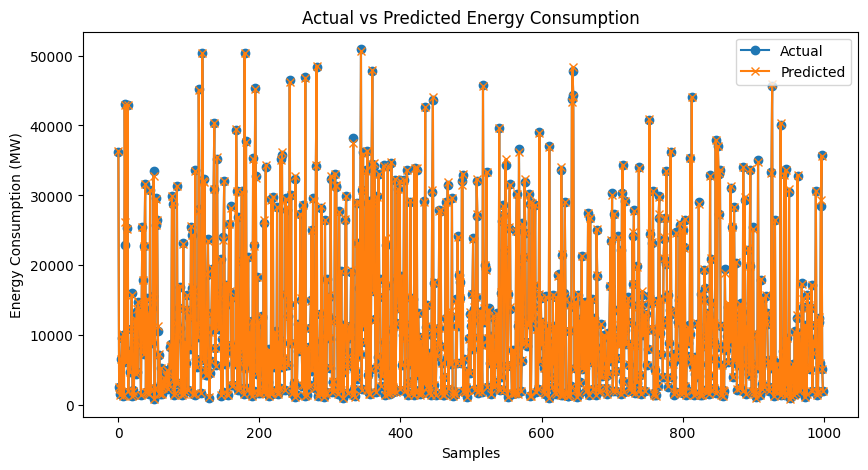

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(y_test.values[:1000], label = 'Actual', marker = 'o')
plt.plot(y_pred[:1000], label = 'Predicted', marker = 'x')
plt.xlabel('Samples')
plt.ylabel('Energy Consumption (MW)')
plt.title('Actual vs Predicted Energy Consumption')
plt.legend()
plt.show()